# Gradient Bandit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4

## Helper functions

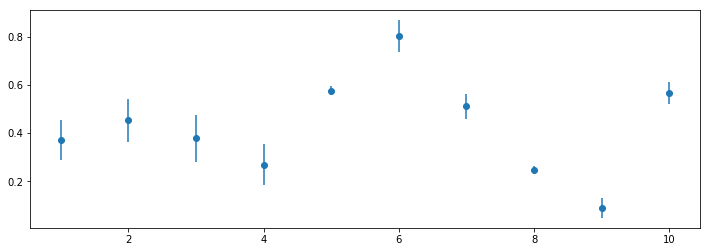

In [2]:
class Bandit:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def roll(self):
        return np.random.normal(self.mean, self.std)
    

def random_bandits(k, max_mean=1.0, max_std=0.1):
    bs = []
    for _ in range(k):
        mean = np.random.uniform(0.0, max_mean)
        std = np.random.uniform(0.0, max_std)
        bs.append(Bandit(mean, std))
    return bs
    
    
def plot_bandits(bs):
    x = np.array(np.linspace(1, k, k))
    y = [x.mean for x in bandits]
    e = [x.std for x in bandits]
    plt.errorbar(x, y, e, linestyle='None', marker='o')
    plt.show()    
    
    
def moving_average(xs, n=100):
    cs = np.cumsum(xs, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    return cs[n - 1:] / n    


# Sample bandits
k = 10
bandits = random_bandits(k)
plot_bandits(bandits)

## Helper function for agents learning

In [3]:
class Agent:
    
    def choose_action(self):
        return 0
    
    def learn(self, action, reward):
        pass
    
    
def evaluate(agent, bandits, num_episodes=1000, window=10):
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, window)

# AlphaAgent

This agent keeps expected reward for each action.

In [4]:
class AlphaAgent:
    
    def __init__(self, k=10, epsilon=0.1, alpha=0.1):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + self.alpha*(reward-self.Q[action])

## GradientAgent

This agent uses preference function $H_{t}(a)$ for selecting action

The probabilities are calculated using softmax over preference function:

$$ Pr\{A_{t}=a\} = \frac{e^{H_{t}(a)}}{\sum\limits_{b=1}^{k} e^{H_{t}(b)}} = \pi_{t}(a)$$

What is characteristic is the the value of the preference function doesn't matter. What is important is relative preferences (Thanks to the softmax). So if we add 100 for each action we will end up with the same probabilities.

In [5]:
class GradientAgent:
    
    def __init__(self, k=10, epsilon=0.1, alpha=0.1):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.H = np.zeros(k)
        self.Q = np.zeros(k)
        
    def choose_action(self):
        return np.random.choice(self.k, 1, p=self.softmax())[0]
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + 0.1*(reward-self.Q[action])
        pi = self.softmax()
        for i in range(self.k):
            if i == action:
                self.H[i] = self.H[i] + self.alpha*(reward-self.Q[i])*(1.0-pi[i])
            else:
                self.H[i] = self.H[i] - self.alpha*(reward-self.Q[i])*pi[i]
        
    def softmax(self):
        "Return list of probabilities"
        H_exp = np.exp(self.H)
        return H_exp / np.sum(H_exp)

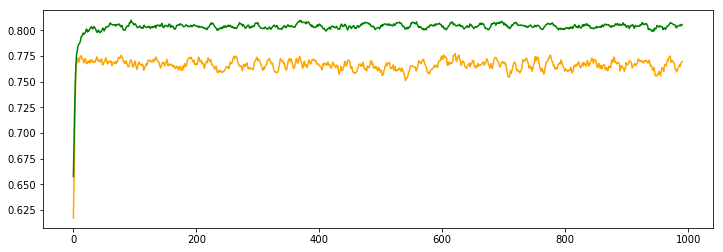

In [8]:
plt.plot(evaluate(AlphaAgent(k), bandits), color='orange')
plt.plot(evaluate(GradientAgent(k, alpha=0.1), bandits), color='green')
plt.show()

The GradientAgent can escpae local maxima and learns better policy.